# Momentum and vorticity budgets in continuously-strafied z* model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xarray as xr
from xgcm import Grid
import dask 
import dask.distributed
%matplotlib inline

In [2]:
from dask.distributed import Client
from dask.distributed import LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:46049 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 270.45 GB


# Momentum budget

First look at all terms in the momentum budget at different times. All terms in the momentum budget are represented in the equation below. Some of the terms are not relevant for a stacked shallow water model.

\begin{equation}
\left[ \frac{\partial \mathbf{u}}{\partial t} \right]_{s} =
- \left[ \frac{f + \zeta}{h} \right] \hat{\mathbf{z}} \wedge (h \, \mathbf{u}) 
- w^{(\dot{s})} \, \frac{\partial \mathbf{u}}{\partial z}
-\left[ \rho^{-1} \, \nabla_s \, p + \nabla_s \Phi \right]
- \nabla_{s} K 
+ \boldsymbol{F}^{({\mbox{\tiny horz frict}})}
+ \boldsymbol{F}^{({\mbox{\tiny vert frict}})}
+ \rho^{-1} \, \boldsymbol{\tau}^{(\mbox{\tiny bound})} 
\label{eq:continuous-velocity-equation}
\end{equation}
where we have 
\begin{alignat}{2}
\boldsymbol{v} &= \boldsymbol{u} + \hat{\boldsymbol{z}} \, w
= \hat{\boldsymbol{x}} \, u  +  \hat{\boldsymbol{y}} \, v
 + \hat{\boldsymbol{z}} \, w
&\mbox{velocity}
\\
\nabla_{s} &= 
\hat{\boldsymbol{x}} \left[ \frac{\partial}{\partial x} \right]_{s}
+
\hat{\boldsymbol{y}} \left[ \frac{\partial}{\partial y} \right]_{s}
&\mbox{horizontal gradient on $s$-surface}
\\
w^{(\dot{s})} &= \frac{\partial z}{\partial s} \, \frac{\mathrm{D}s}{\mathrm{D}t}
&\mbox{dia-surface velocity used for remapping}
\\
\zeta &= \left[ \frac{\partial v}{\partial x} \right]_{s} 
        -\left[ \frac{\partial u}{\partial y} \right]_{s} 
&\mbox{$s$-coordinate vertical vorticity}
\\
\Phi &= g \, z \qquad 
&\mbox{geopotential (more complex when have tides)}
\\
-\rho^{-1} \, \nabla_{z}p  &= 
-\left[ \rho^{-1} \, \nabla_s \, p + \nabla_s \Phi \right]
\qquad &\mbox{horizontal pressure acceleration} 
\\
K &= \frac{u^{2} + v^{2}}{2}  \qquad 
&\mbox{horizontal kinetic energy per mass}
\\
\boldsymbol{F}^{({\mbox{\tiny horz frict}})} &= 
\mbox{horiz friction from horz shear} &\mbox{Laplacian or biharmonic}
\\
\boldsymbol{F}^{({\mbox{\tiny vert frict}})} &= 
\mbox{vert friction from vertical shear} &\mbox{Laplacian}
\\
\rho^{-1} \, \boldsymbol{\tau}^{(\mbox{\tiny bound})} &=
\mbox{boundary frictional acceleration} &\mbox{wind, bottom drag, etc.}
\end{alignat}

In [3]:
ppdir = "/work/Hemant.Khatri/MOM6_idealised/MOM_budget/Cont_Strat/z_star/"
ds = xr.open_mfdataset(ppdir + "*.nc", chunks={'Time': 1}, combine='by_coords', decode_times=False)

In [4]:
ds

<xarray.Dataset>
Dimensions:                      (Time: 101, xh: 240, xq: 240, yh: 160, yq: 160, zl: 50)
Coordinates:
  * Time                         (Time) float64 0.0 3.651e+03 ... 3.75e+03
  * xq                           (xq) float64 0.25 0.5 0.75 ... 59.5 59.75 60.0
  * yh                           (yh) float64 -54.27 -54.13 ... -24.58 -24.36
  * zl                           (zl) float64 0.5 2.674 ... 3.75e+03 3.916e+03
  * xh                           (xh) float64 0.125 0.375 0.625 ... 59.62 59.87
  * yq                           (yq) float64 -54.2 -54.05 ... -24.47 -24.24
Data variables:
    dudt                         (Time, zl, yh, xq) float64 dask.array<chunksize=(2, 50, 160, 240), meta=np.ndarray>
    dvdt                         (Time, zl, yq, xh) float64 dask.array<chunksize=(2, 50, 160, 240), meta=np.ndarray>
    CAu                          (Time, zl, yh, xq) float64 dask.array<chunksize=(2, 50, 160, 240), meta=np.ndarray>
    CAv                          (Time, zl, y

$\large \text{Layerwise Momentum and Vorticity Budgets}$

We first look at layerwise momentum and voticity budgets. 

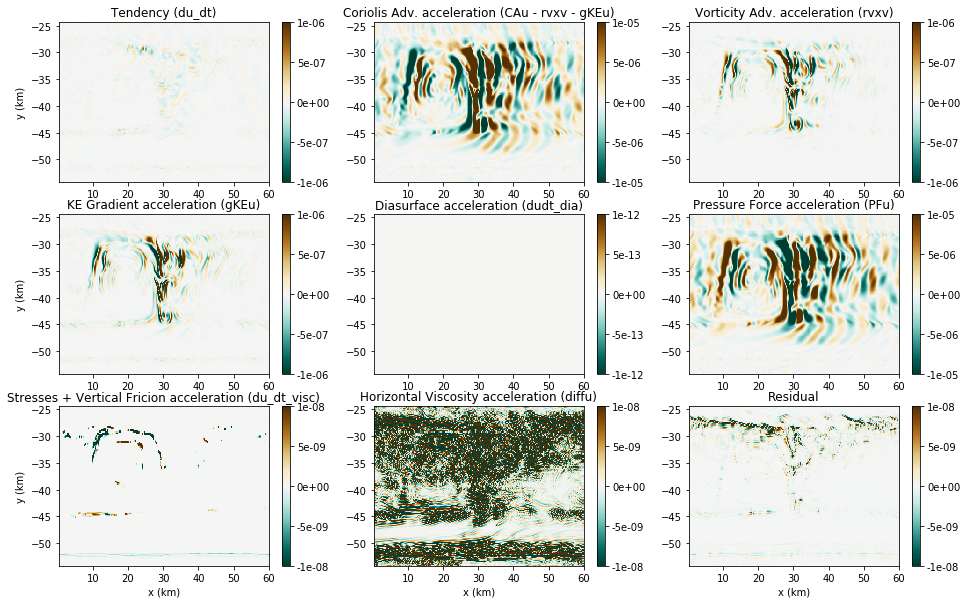

In [5]:
# Zonal Momentum budget
idx = 25
plt.figure(figsize=(16,10))
max_r = 1.e-6

for i in range(10,11):
    plt.subplot(3,3,1)
    plt.pcolor(ds['xq'], ds['yh'], ds['dudt'].isel(Time=idx, zl=i), vmin = -max_r, 
             vmax = max_r, cmap='BrBG_r')
    plt.title('Tendency (du_dt)')
    plt.colorbar(format='%.0e')
    plt.ylabel('y (km)')
    
    plt.subplot(3,3,2)
    plt.pcolor(ds['xq'], ds['yh'], (ds['CAu']-ds['rvxv']-ds['gKEu']).isel(Time=idx, zl=i), vmin = -1.e1*max_r, 
             vmax = 1.e1*max_r, cmap='BrBG_r')
    plt.title('Coriolis Adv. acceleration (CAu - rvxv - gKEu)')
    plt.colorbar(format='%.0e')
    
    plt.subplot(3,3,3)
    plt.pcolor(ds['xq'], ds['yh'], (ds['rvxv']).isel(Time=idx, zl=i), vmin = -max_r, 
             vmax = max_r, cmap='BrBG_r')
    plt.title('Vorticity Adv. acceleration (rvxv)')
    plt.colorbar(format='%.0e')
        
    plt.subplot(3,3,4)
    plt.pcolor(ds['xq'], ds['yh'], (ds['gKEu']).isel(Time=idx, zl=i), vmin = -max_r, 
             vmax = max_r, cmap='BrBG_r')
    plt.title('KE Gradient acceleration (gKEu)')
    plt.colorbar(format='%.0e')
    plt.ylabel('y (km)')
        
    plt.subplot(3,3,5)
    plt.pcolor(ds['xq'], ds['yh'], (ds['dudt_dia']).isel(Time=idx, zl=i), vmin = -1.e-6*max_r, 
             vmax = 1.e-6*max_r, cmap='BrBG_r')
    plt.title('Diasurface acceleration (dudt_dia)')
    plt.colorbar(format='%.0e')
    
    plt.subplot(3,3,6)
    plt.pcolor(ds['xq'], ds['yh'], ds['PFu'].isel(Time=idx, zl=i), vmin = -1.e1*max_r, 
             vmax = 1.e1*max_r, cmap='BrBG_r')
    plt.title('Pressure Force acceleration (PFu)')
    plt.colorbar(format='%.0e')
    
    plt.subplot(3,3,7)
    plt.pcolor(ds['xq'], ds['yh'], ds['du_dt_visc'].isel(Time=idx, zl=i), vmin = -1e-2*max_r, 
             vmax = 1e-2*max_r, cmap='BrBG_r')
    plt.title('Stresses + Vertical Fricion acceleration (du_dt_visc)')
    plt.colorbar(format='%.0e')
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    
    plt.subplot(3,3,8)
    plt.pcolor(ds['xq'], ds['yh'], ds['diffu'].isel(Time=idx, zl=i), vmin = -1e-2*max_r, 
             vmax = 1e-2*max_r, cmap='BrBG_r')
    plt.title('Horizontal Viscosity acceleration (diffu)')
    plt.colorbar(format='%.0e')
    plt.xlabel('x (km)')
    
    plt.subplot(3,3,9)
    plt.pcolor(ds['xq'], ds['yh'], (ds['dudt']-ds['CAu']-ds['dudt_dia']-ds['PFu']-ds['diffu']-ds['du_dt_visc']).isel(Time=idx, zl=i)
               - ds['u_BT_accel'].isel(Time = idx, zl=i), vmin = -1e-2*max_r, vmax = 1e-2*max_r, cmap='BrBG_r')
    plt.xlabel('x (km)')
    plt.title('Residual')
    plt.colorbar(format='%.0e')

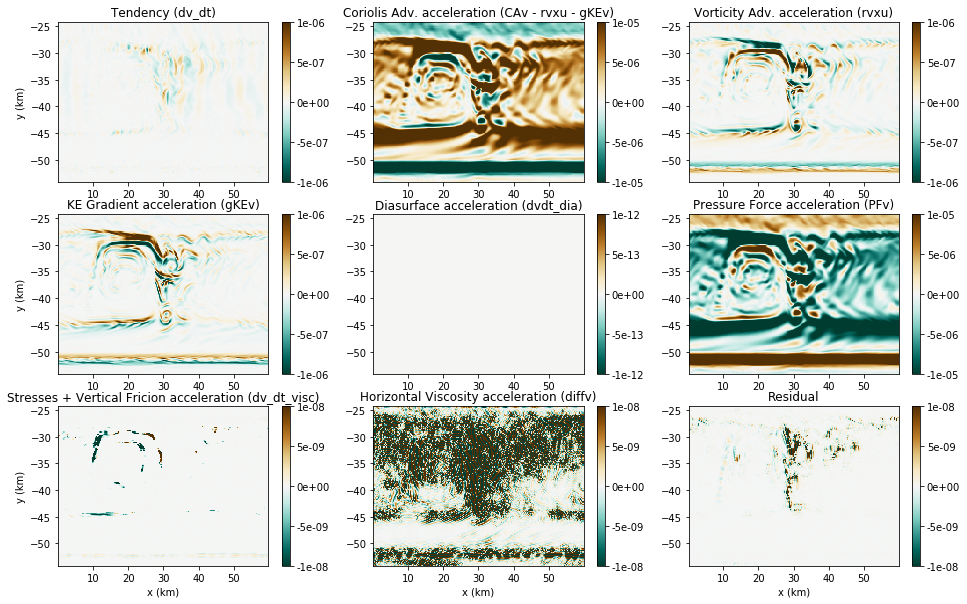

In [23]:
# Meridional Momentum budget
idx = 20
plt.figure(figsize=(16,10))
max_r = 1.e-6

for i in range(10,11):
    plt.subplot(3,3,1)
    plt.pcolor(ds['xh'], ds['yq'], ds['dvdt'].isel(Time=idx, zl=i), vmin = -max_r, 
             vmax = max_r, cmap='BrBG_r')
    plt.title('Tendency (dv_dt)')
    plt.colorbar(format='%.0e')
    plt.ylabel('y (km)')
    
    plt.subplot(3,3,2)
    plt.pcolor(ds['xh'], ds['yq'], (ds['CAv']-ds['rvxu']-ds['gKEv']).isel(Time=idx, zl=i), vmin = -1.e1*max_r, 
             vmax = 1.e1*max_r, cmap='BrBG_r')
    plt.title('Coriolis Adv. acceleration (CAv - rvxu - gKEv)')
    plt.colorbar(format='%.0e')
    
    plt.subplot(3,3,3)
    plt.pcolor(ds['xh'], ds['yq'], (ds['rvxu']).isel(Time=idx, zl=i), vmin = -max_r, 
             vmax = max_r, cmap='BrBG_r')
    plt.title('Vorticity Adv. acceleration (rvxu)')
    plt.colorbar(format='%.0e')
        
    plt.subplot(3,3,4)
    plt.pcolor(ds['xh'], ds['yq'], (ds['gKEv']).isel(Time=idx, zl=i), vmin = -max_r, 
             vmax = max_r, cmap='BrBG_r')
    plt.title('KE Gradient acceleration (gKEv)')
    plt.colorbar(format='%.0e')
    plt.ylabel('y (km)')
        
    plt.subplot(3,3,5)
    plt.pcolor(ds['xh'], ds['yq'], (ds['dvdt_dia']).isel(Time=idx, zl=i), vmin = -1.e-6*max_r, 
             vmax = 1.e-6*max_r, cmap='BrBG_r')
    plt.title('Diasurface acceleration (dvdt_dia)')
    plt.colorbar(format='%.0e')
    
    plt.subplot(3,3,6)
    plt.pcolor(ds['xh'], ds['yq'], ds['PFv'].isel(Time=idx, zl=i), vmin = -1.e1*max_r, 
             vmax = 1.e1*max_r, cmap='BrBG_r')
    plt.title('Pressure Force acceleration (PFv)')
    plt.colorbar(format='%.0e')
    
    plt.subplot(3,3,7)
    plt.pcolor(ds['xh'], ds['yq'], ds['dv_dt_visc'].isel(Time=idx, zl=i), vmin = -1e-2*max_r, 
             vmax = 1e-2*max_r, cmap='BrBG_r')
    plt.title('Stresses + Vertical Fricion acceleration (dv_dt_visc)')
    plt.colorbar(format='%.0e')
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    
    plt.subplot(3,3,8)
    plt.pcolor(ds['xh'], ds['yq'], ds['diffv'].isel(Time=idx, zl=i), vmin = -1e-2*max_r, 
             vmax = 1e-2*max_r, cmap='BrBG_r')
    plt.title('Horizontal Viscosity acceleration (diffv)')
    plt.colorbar(format='%.0e')
    plt.xlabel('x (km)')
    
    plt.subplot(3,3,9)
    plt.pcolor(ds['xh'], ds['yq'], (ds['dvdt']-ds['CAv']-ds['dvdt_dia']-ds['PFv']-ds['diffv']-ds['dv_dt_visc']).isel(Time=idx, zl=i)
               - ds['v_BT_accel'].isel(Time = idx, zl=i), vmin = -1e-2*max_r, vmax = 1e-2*max_r, cmap='BrBG_r')
    plt.xlabel('x (km)')
    plt.title('Residual')
    plt.colorbar(format='%.0e')

In [14]:
# Vorticity Computation
# Vorticity Budget

grid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'} }, periodic=['X'])

dzeta_dt = ( - grid.diff(ds['dudt']/ds['dyCu'], 'Y', boundary='fill')
            + grid.diff(ds['dvdt']/ds['dxCv'], 'X', boundary='fill') ) 

zeta_CA = ( - grid.diff(ds['CAu']/ds['dyCu'], 'Y', boundary='fill')
           + grid.diff(ds['CAv']/ds['dxCv'], 'X', boundary='fill') ) 

zeta_PF = ( - grid.diff(ds['PFu']/ds['dyCu'], 'Y', boundary='fill')
           + grid.diff(ds['PFv']/ds['dxCv'], 'X', boundary='fill') ) 

zeta_RV = ( - grid.diff(ds['rvxv']/ds['dyCu'], 'Y', boundary='fill')
           + grid.diff(ds['rvxu']/ds['dxCv'], 'X', boundary='fill') ) 

zeta_KE = ( - grid.diff(ds['gKEu']/ds['dyCu'], 'Y', boundary='fill')
           + grid.diff(ds['gKEv']/ds['dxCv'], 'X', boundary='fill') ) 

zeta_dia = ( - grid.diff(ds['dudt_dia']/ds['dyCu'], 'Y', boundary='fill')
           + grid.diff(ds['dvdt_dia']/ds['dxCv'], 'X', boundary='fill') ) 

zeta_diff = ( - grid.diff(ds['diffu']/ds['dyCu'], 'Y', boundary='fill')
             + grid.diff(ds['diffv']/ds['dxCv'], 'X', boundary='fill') ) 

zeta_visc = ( - grid.diff(ds['du_dt_visc']/ds['dyCu'], 'Y', boundary='fill')
             + grid.diff(ds['dv_dt_visc']/ds['dxCv'], 'X', boundary='fill') ) 

zeta_BT_accel = ( - grid.diff(ds['u_BT_accel']/ds['dyCu'], 'Y', boundary='fill')
                 + grid.diff(ds['v_BT_accel']/ds['dxCv'], 'X', boundary='fill') ) 

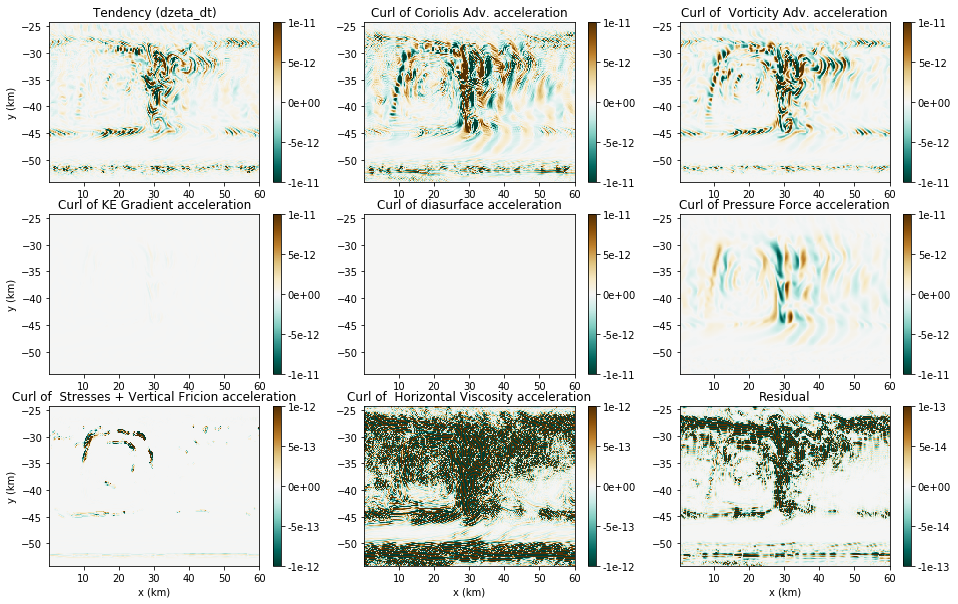

In [19]:
# Vorticity Momentum Budget
idx = 20 
plt.figure(figsize=(16,10))
max_r = 1.e-11

for i in range(10,11):
    plt.subplot(3,3,1)
    plt.pcolormesh(ds['xq'], ds['yq'], dzeta_dt.isel(Time=idx, zl=i), vmin = -max_r, vmax = max_r, cmap='BrBG_r')
    plt.title('Tendency (dzeta_dt)')
    plt.colorbar(format='%.0e')
    plt.ylabel('y (km)')
    
    plt.subplot(3,3, 2)
    plt.pcolor(ds['xq'], ds['yq'], (zeta_CA - zeta_RV - zeta_KE).isel(Time=idx, zl=i), vmin = -1.e0*max_r, 
             vmax = 1.e0*max_r, cmap='BrBG_r')
    plt.title('Curl of Coriolis Adv. acceleration')
    plt.colorbar(format='%.0e')
    
    plt.subplot(3,3, 3)
    plt.pcolor(ds['xq'], ds['yq'], (zeta_RV).isel(Time=idx, zl=i), vmin = -max_r, 
             vmax = max_r, cmap='BrBG_r')
    plt.title('Curl of  Vorticity Adv. acceleration')
    plt.colorbar(format='%.0e')
        
    plt.subplot(3,3, 4)
    plt.pcolor(ds['xq'], ds['yq'], (zeta_KE).isel(Time=idx, zl=i), vmin = -max_r, 
             vmax = max_r, cmap='BrBG_r')
    plt.title('Curl of KE Gradient acceleration')
    plt.colorbar(format='%.0e')
    plt.ylabel('y (km)')
    
    plt.subplot(3,3, 5)
    plt.pcolor(ds['xq'], ds['yq'], (zeta_dia).isel(Time=idx, zl=i), vmin = -max_r, 
             vmax = max_r, cmap='BrBG_r')
    plt.title('Curl of diasurface acceleration')
    plt.colorbar(format='%.0e')
    
    plt.subplot(3,3, 6)
    plt.pcolor(ds['xq'], ds['yq'], (zeta_PF +zeta_BT_accel).isel(Time=idx, zl=i), vmin = -1.e0*max_r, 
             vmax = 1.e0*max_r, cmap='BrBG_r')
    plt.title('Curl of Pressure Force acceleration')
    plt.colorbar(format='%.0e')
    
    plt.subplot(3,3, 7)
    plt.pcolor(ds['xq'], ds['yq'], zeta_visc.isel(Time=idx, zl=i), vmin = -1e-1*max_r, 
             vmax = 1e-1*max_r, cmap='BrBG_r')
    plt.title('Curl of  Stresses + Vertical Fricion acceleration')
    plt.colorbar(format='%.0e')
    plt.ylabel('y (km)')
    plt.xlabel('x (km)')
    
    plt.subplot(3,3, 8)
    plt.pcolor(ds['xq'], ds['yq'], zeta_diff.isel(Time=idx, zl=i), vmin = -1e-1*max_r, 
             vmax = 1e-1*max_r, cmap='BrBG_r')
    plt.title('Curl of  Horizontal Viscosity acceleration')
    plt.colorbar(format='%.0e')
    plt.xlabel('x (km)')
    
    plt.subplot(3,3,9)
    plt.pcolor(ds['xq'], ds['yh'], (dzeta_dt-zeta_CA-zeta_PF-zeta_diff-zeta_visc).isel(Time=idx, zl=i)
               - zeta_BT_accel.isel(Time = idx, zl=i), vmin = -1e-2*max_r, vmax = 1e-2*max_r, cmap='BrBG_r')
    plt.xlabel('x (km)')
    plt.title('Residual')
    plt.colorbar(format='%.0e')
    plt.xlabel('x (km)')

$\Large \text{Barotropic Momentum Budget}$

The barotropic velocity tendency term is given as,

\begin{equation}
    \frac{\partial}{\partial t} 
    \left[ \sum_{k} (h_{k}/H) \, \boldsymbol{u}_{k}
    \right]
    =
    \left[ \sum_{k} \partial_{t} (h_{k}/H) \, \boldsymbol{u}_{k}
    +
    \sum_{k} (h_{k}/H) \, \partial_{t} \boldsymbol{u}_{k}
    \right].
\end{equation} 

Since MOM6 uses vector-invariant form the governing equations, calculus manipulations may not agree with the numerics. Therefore, we compute barotropic velocity tendency online and use this compute the contribution due to the first term on the RHS.

\begin{equation}
\sum_{k} \partial_{t} (h_{k}/H) \, \boldsymbol{u}_{k}
 =
  \frac{\overline{u}(\tau + \Delta \tau)
          - \overline{u}(\tau)}{\Delta \tau}
 -
 \sum_{k} (h_{k}/H) \, \partial_{t} \boldsymbol{u}_{k},
\end{equation}

If the variation in the total depth H is small, then we can use the following approaximation,

\begin{equation}
    \frac{\partial}{\partial t} 
    \left[ \sum_{k} (h_{k}/H) \, \boldsymbol{u}_{k}
    \right]
    \approx
    \frac{1}{H}\left[\sum_{k} \partial_{t} (h_{k}) \, \boldsymbol{u}_{k}
    +
    \sum_{k} (h_{k}) \, \partial_{t} \boldsymbol{u}_{k}
    \right].
\end{equation}

We check if the relationship holds good. The figure below shows that the most of the contribution in the barotropic velocity tendemcy term is due to $\sum_{k} \partial_{t} (h_{k}/H) \, \boldsymbol{u}_{k}$ and the thickness tendency term makes little difference. Also, the assumption in the last equation shown above makes the residual larger instead. Therefore, it is better to use the following

\begin{equation}
    \frac{\partial}{\partial t} 
    \left[ \sum_{k} (h_{k}/H) \, \boldsymbol{u}_{k}
    \right]
    \approx
    \frac{1}{H}\left[
    \sum_{k} (h_{k}) \, \partial_{t} \boldsymbol{u}_{k}
    \right].
\end{equation}

The depth-averaged velocity is given by 
\begin{equation}
  \overline{\zeta} = 
  \frac{ \sum_{k} h_{k} \, \zeta_{k}}{\sum_{k} h_{k}}
  =
  \sum_{k} (h_{k}/H) \, \zeta_{k}.
\label{eq:barotropic-vorticity}
\end{equation}

Similar to the method adopted for the depth-averaged vorticity, we can write the time derivative of the depth averaged vorticity as 
\begin{equation}
    \frac{\partial}{\partial t} 
    \left[ \sum_{k} (h_{k}/H) \, \zeta_{k}
    \right]
    =
    \left[ \sum_{k} \partial_{t} (h_{k}/H) \, \zeta_{k}
    +
    \sum_{k} (h_{k}/H) \, \partial_{t} \zeta_{k}
    \right].
\label{eq:time-derivative-vorticity-barotropic}
\end{equation} 

In [20]:
grid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'} }, periodic=['X'])

hdudt = (grid.interp(ds['h'],'X')*ds['dudt']).sum('zl')/grid.interp(ds['h'],'X').sum('zl')
hdvdt = (grid.interp(ds['h'],'Y',boundary='fill')*ds['dvdt']).sum('zl')/grid.interp(ds['h'],'Y',boundary='fill').sum('zl')

udhdt = (ds['u']*grid.interp(ds['dhdt'],'X')).sum('zl')/grid.interp(ds['h'],'X').sum('zl')
vdhdt = (ds['v']*grid.interp(ds['dhdt'],'Y',boundary='fill')).sum('zl')/grid.interp(ds['h'],'Y',boundary='fill').sum('zl')

CAu = (grid.interp(ds['h'],'X')*ds['CAu']).sum('zl')/grid.interp(ds['h'],'X').sum('zl')
CAv = (grid.interp(ds['h'],'Y',boundary='fill')*ds['CAv']).sum('zl')/grid.interp(ds['h'],'Y',boundary='fill').sum('zl')

RVu = (grid.interp(ds['h'],'X')*ds['rvxv']).sum('zl')/grid.interp(ds['h'],'X').sum('zl')
RVv = (grid.interp(ds['h'],'Y',boundary='fill')*ds['rvxu']).sum('zl')/grid.interp(ds['h'],'Y',boundary='fill').sum('zl')

gKEu = (grid.interp(ds['h'],'X')*ds['gKEu']).sum('zl')/grid.interp(ds['h'],'X').sum('zl')
gKEv = (grid.interp(ds['h'],'Y',boundary='fill')*ds['gKEv']).sum('zl')/grid.interp(ds['h'],'Y',boundary='fill').sum('zl')

PFu = (grid.interp(ds['h'],'X')*ds['PFu']).sum('zl')/grid.interp(ds['h'],'X').sum('zl')
PFv = (grid.interp(ds['h'],'Y',boundary='fill')*ds['PFv']).sum('zl')/grid.interp(ds['h'],'Y',boundary='fill').sum('zl')

diffu = (grid.interp(ds['h'],'X')*ds['diffu']).sum('zl')/grid.interp(ds['h'],'X').sum('zl')
diffv = (grid.interp(ds['h'],'Y',boundary='fill')*ds['diffv']).sum('zl')/grid.interp(ds['h'],'Y',boundary='fill').sum('zl')

visc_u = (grid.interp(ds['h'],'X')*ds['du_dt_visc']).sum('zl')/grid.interp(ds['h'],'X').sum('zl')
visc_v = (grid.interp(ds['h'],'Y',boundary='fill')*ds['dv_dt_visc']).sum('zl')/grid.interp(ds['h'],'Y',boundary='fill').sum('zl')

u_BT_accel = (grid.interp(ds['h'],'X')*ds['u_BT_accel']).sum('zl')/grid.interp(ds['h'],'X').sum('zl')
v_BT_accel = (grid.interp(ds['h'],'Y',boundary='fill')*ds['v_BT_accel']).sum('zl')/grid.interp(ds['h'],'Y',boundary='fill').sum('zl')

Text(0.5, 0, 'x (km)')

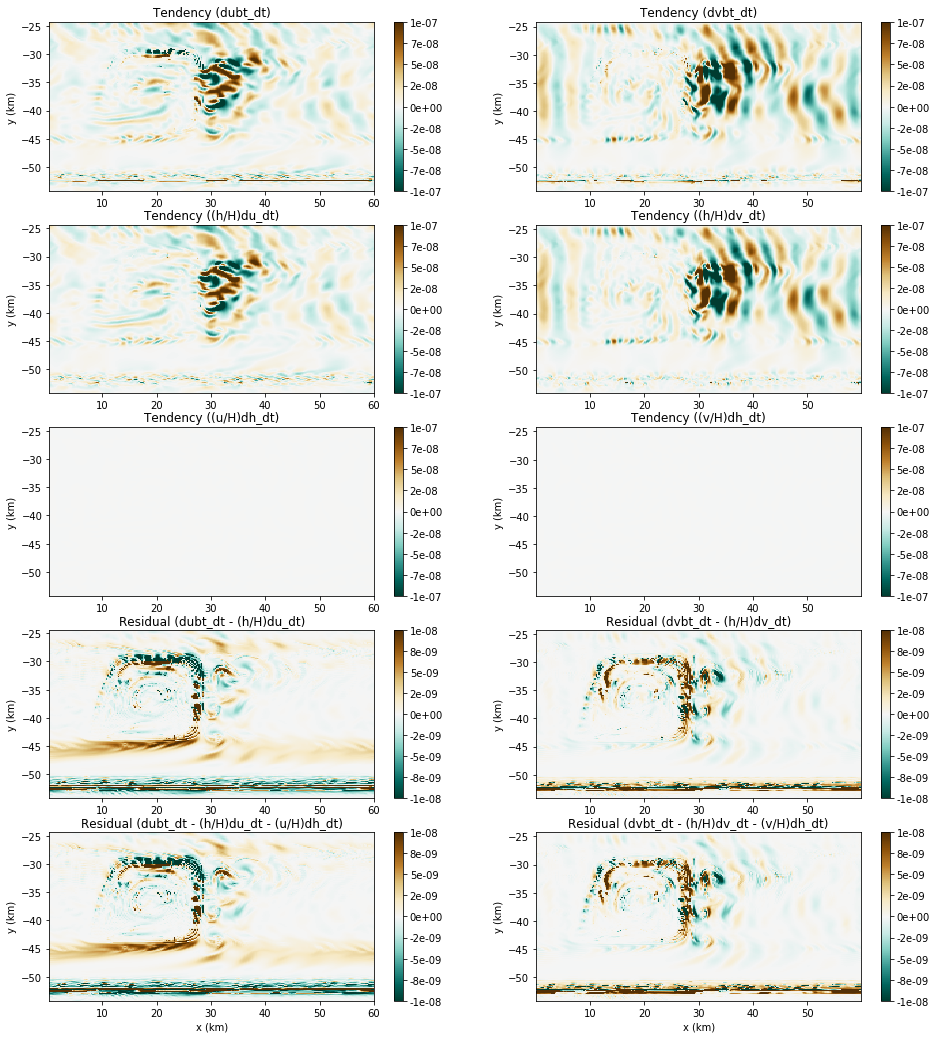

In [23]:
# Compare tendency terms
idx = 5

i = 0
plt.figure(figsize=(16,18))
max_r = [1.e-7, 1.e-7]

plt.subplot(5,2,1)
plt.pcolormesh(ds['xq'], ds['yh'], ds['ubt_dt'].isel(Time=idx), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('Tendency (dubt_dt)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(5,2,2)
plt.pcolormesh(ds['xh'], ds['yq'], ds['vbt_dt'].isel(Time=idx), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('Tendency (dvbt_dt)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(5,2,3)
plt.pcolormesh(ds['xq'], ds['yh'], hdudt.isel(Time=idx), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('Tendency ((h/H)du_dt)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(5,2,4)
plt.pcolormesh(ds['xh'], ds['yq'], hdvdt.isel(Time=idx), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('Tendency ((h/H)dv_dt)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(5,2,5)
plt.pcolormesh(ds['xq'], ds['yh'], (udhdt+0*hdudt).isel(Time=idx), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('Tendency ((u/H)dh_dt)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(5,2,6)
plt.pcolormesh(ds['xh'], ds['yq'], (vdhdt+0*hdvdt).isel(Time=idx), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('Tendency ((v/H)dh_dt)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(5,2,7)
plt.pcolormesh(ds['xq'], ds['yh'], (ds['ubt_dt']-0*udhdt-hdudt).isel(Time=idx), vmin = -0.1*max_r[i], vmax = 0.1*max_r[i], cmap='BrBG_r')
plt.title('Residual (dubt_dt - (h/H)du_dt)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(5,2,8)
plt.pcolormesh(ds['xh'], ds['yq'], (ds['vbt_dt']-0*vdhdt-hdvdt).isel(Time=idx), vmin = -0.1*max_r[i], vmax = 0.1*max_r[i], cmap='BrBG_r')
plt.title('Residual (dvbt_dt - (h/H)dv_dt)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(5,2,9)
plt.pcolormesh(ds['xq'], ds['yh'], (ds['ubt_dt']-udhdt-hdudt).isel(Time=idx), vmin = -0.1*max_r[i], vmax = 0.1*max_r[i], cmap='BrBG_r')
plt.title('Residual (dubt_dt - (h/H)du_dt - (u/H)dh_dt)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.xlabel('x (km)')

plt.subplot(5,2,10)
plt.pcolormesh(ds['xh'], ds['yq'], (ds['vbt_dt']-vdhdt-hdvdt).isel(Time=idx), vmin = -0.1*max_r[i], vmax = 0.1*max_r[i], cmap='BrBG_r')
plt.title('Residual (dvbt_dt - (h/H)dv_dt - (v/H)dh_dt)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.xlabel('x (km)')

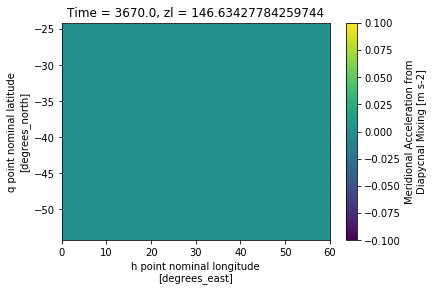

In [19]:
ds['dvdt_dia'].isel(Time = idx, zl=i).plot()

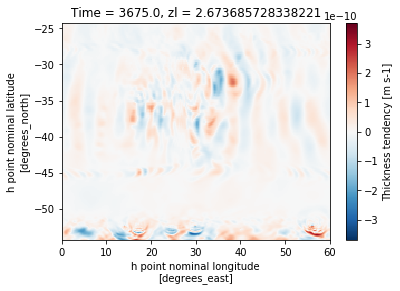

In [12]:
ds['dhdt'].isel(Time = idx, zl=1).plot()

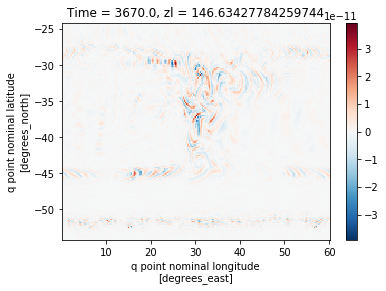

In [17]:
dzeta_dt.isel(Time=idx, zl=10).plot()